# Oasis2_longitudinal_demographics

## 불러오기

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import koreanize_matplotlib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,auc, roc_curve
from sklearn.model_selection import train_test_split

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [4]:
df= pd.read_csv('https://raw.githubusercontent.com/yonghyeun/Dementia_Analysis/main/data/oasis/OASIS.csv')

In [5]:
df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,OAS2_0002_MR1,Mild demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,OAS2_0007_MR1,Mild demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,OAS2_0182,OAS2_0182_MR1,Mild demented,1,0,M,R,73,12,NaN,23.0,0.5,1661,0.698,1.056
156,OAS2_0183,OAS2_0183_MR1,Nondemented,1,0,F,R,66,13,2.0,30.0,0.0,1495,0.746,1.174
157,OAS2_0184,OAS2_0184_MR1,Mild demented,1,0,F,R,72,16,3.0,24.0,0.5,1354,0.733,1.296
158,OAS2_0185,OAS2_0185_MR1,Mild demented,1,0,M,R,80,16,1.0,28.0,0.5,1704,0.711,1.030


In [6]:
def preprocessing(data):
    
    data['M/F'] = data['M/F'].map({'M':0, 'F':1})
    
    data['SES'] = data['SES'].fillna(2).astype(str)
    
    data['label'] = data['CDR'].map({0:0}).fillna(1)
    
    data = data[['M/F', 'EDUC','Age', 'SES', 'eTIV', 'ASF','label']]
    
    data = pd.get_dummies(data)
    
    X = data.drop('label',axis  = 1)
    Y = data['label']
    
    
    return X,Y

In [7]:
X,Y = preprocessing(df)

In [8]:
def min_max(x):
    
    min_ = np.min(x)
    max_ = np.max(x)
    
    return (x - min_) / (max_ - min_)

In [9]:
for col in X.columns:
    
    X[col] = min_max(X[col])

In [10]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42, stratify = Y)

In [11]:
model = LogisticRegression()

model.fit(x_train,y_train)

LogisticRegression()

In [12]:
pred = model.predict(x_test)

In [13]:
f1_score(y_test,pred, average = 'micro')

0.5625

In [17]:
confusion_matrix(y_test,pred)

array([[ 8,  8],
       [ 6, 10]], dtype=int64)

In [18]:
coef = model.coef_.flatten()
odds = np.exp(coef).flatten()

In [19]:
odds_ratio = pd.DataFrame({'cols': x_train.columns,
                'coef': coef,
                'odds': odds})

In [20]:
odds_ratio = odds_ratio.sort_values(by = 'odds', ascending = False)
odds_ratio

,cols,coef,odds
4,ASF,0.507201,1.660637
9,SES_5.0,0.313744,1.368540
2,Age,0.231482,1.260466
8,SES_4.0,0.076176,1.079152
5,SES_1.0,-0.074426,0.928276
7,SES_3.0,-0.127403,0.880379
6,SES_2.0,-0.187742,0.828829
3,eTIV,-0.643464,0.525469
1,EDUC,-1.173432,0.309303
0,M/F,-1.278053,0.278579


Text(0.5, 1.0, '변수에 따른 Odds ratio 변화량')

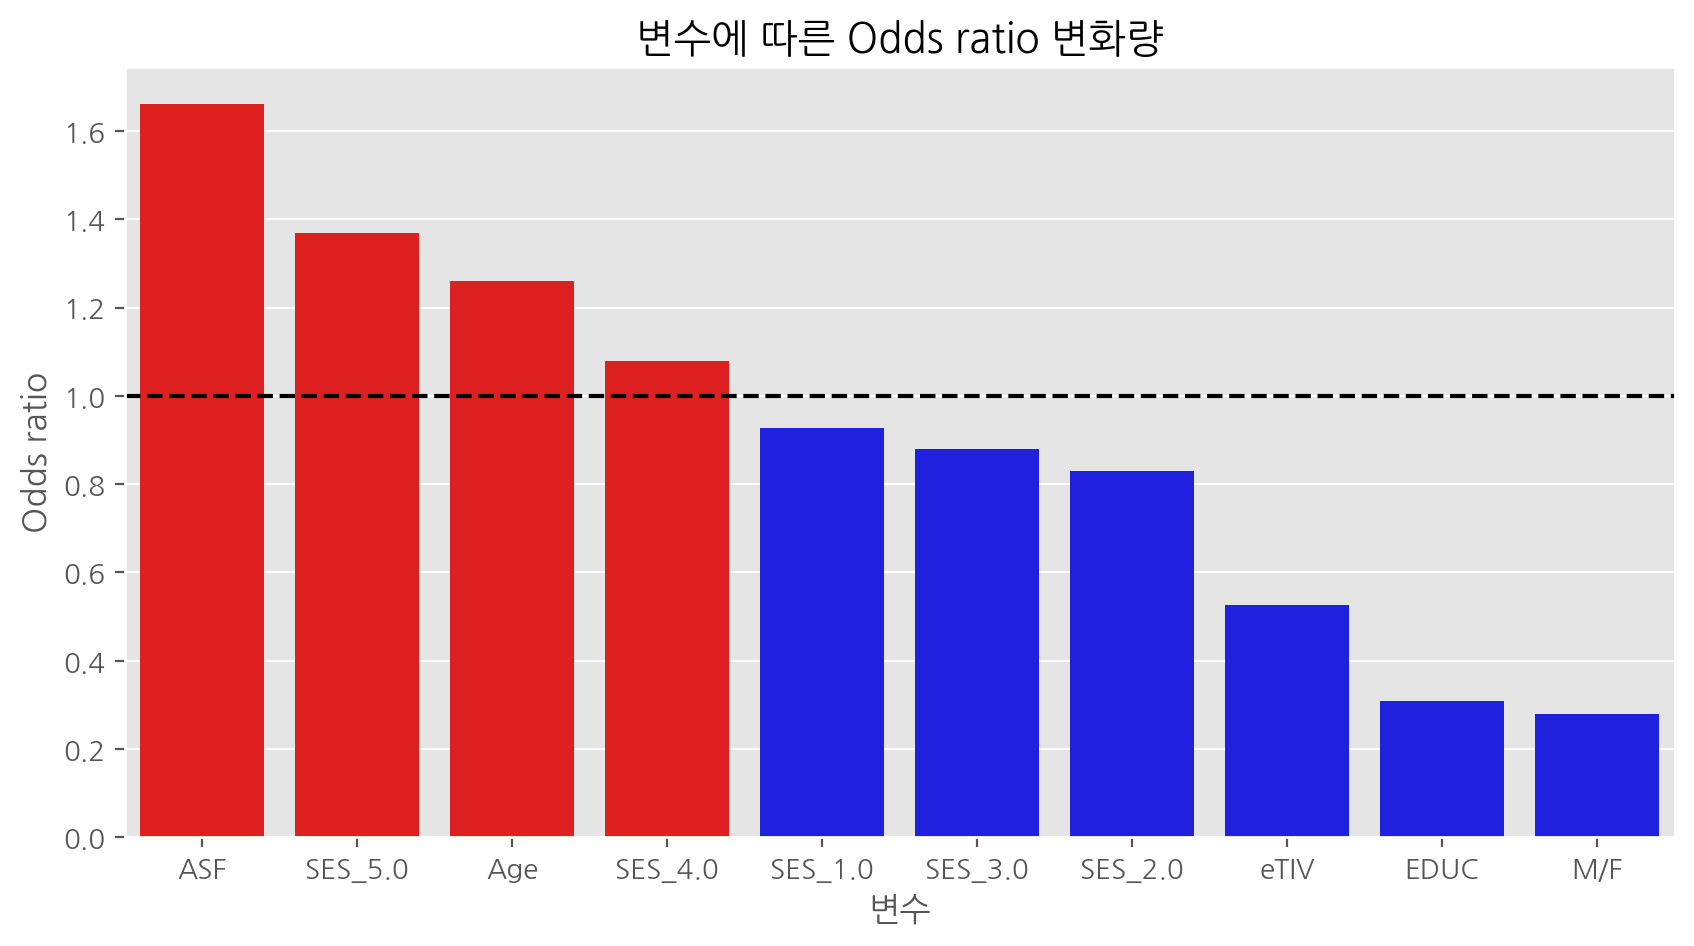

In [21]:
graph_df = odds_ratio.copy()

graph_df['odds_ratio'] = graph_df['odds'] - 1
cmap = ['blue' if x < 1 else 'red' for x in graph_df['odds']]


fig,ax = plt.subplots(figsize = (10,5))

sns.barplot(data = graph_df,
            x = 'cols',
            y = 'odds',
            palette = cmap,
            ax = ax)

ax.axhline(1, c = 'k', ls = '--')

ticks = [round(x,1) for x in ax.get_xticks() + 1]
ax.set_xlabel('변수')
ax.set_ylabel('Odds ratio')
ax.set_title('변수에 따른 Odds ratio 변화량')

In [22]:
tree = RandomForestClassifier()

tree.fit(x_train,y_train)

RandomForestClassifier()

In [23]:
importance = pd.DataFrame({'feature': x_train.columns,
                'importance': tree.feature_importances_}).sort_values(by = 'importance',
                                                                        ascending = False)

Text(0.5, 1.0, 'Feature Importance')

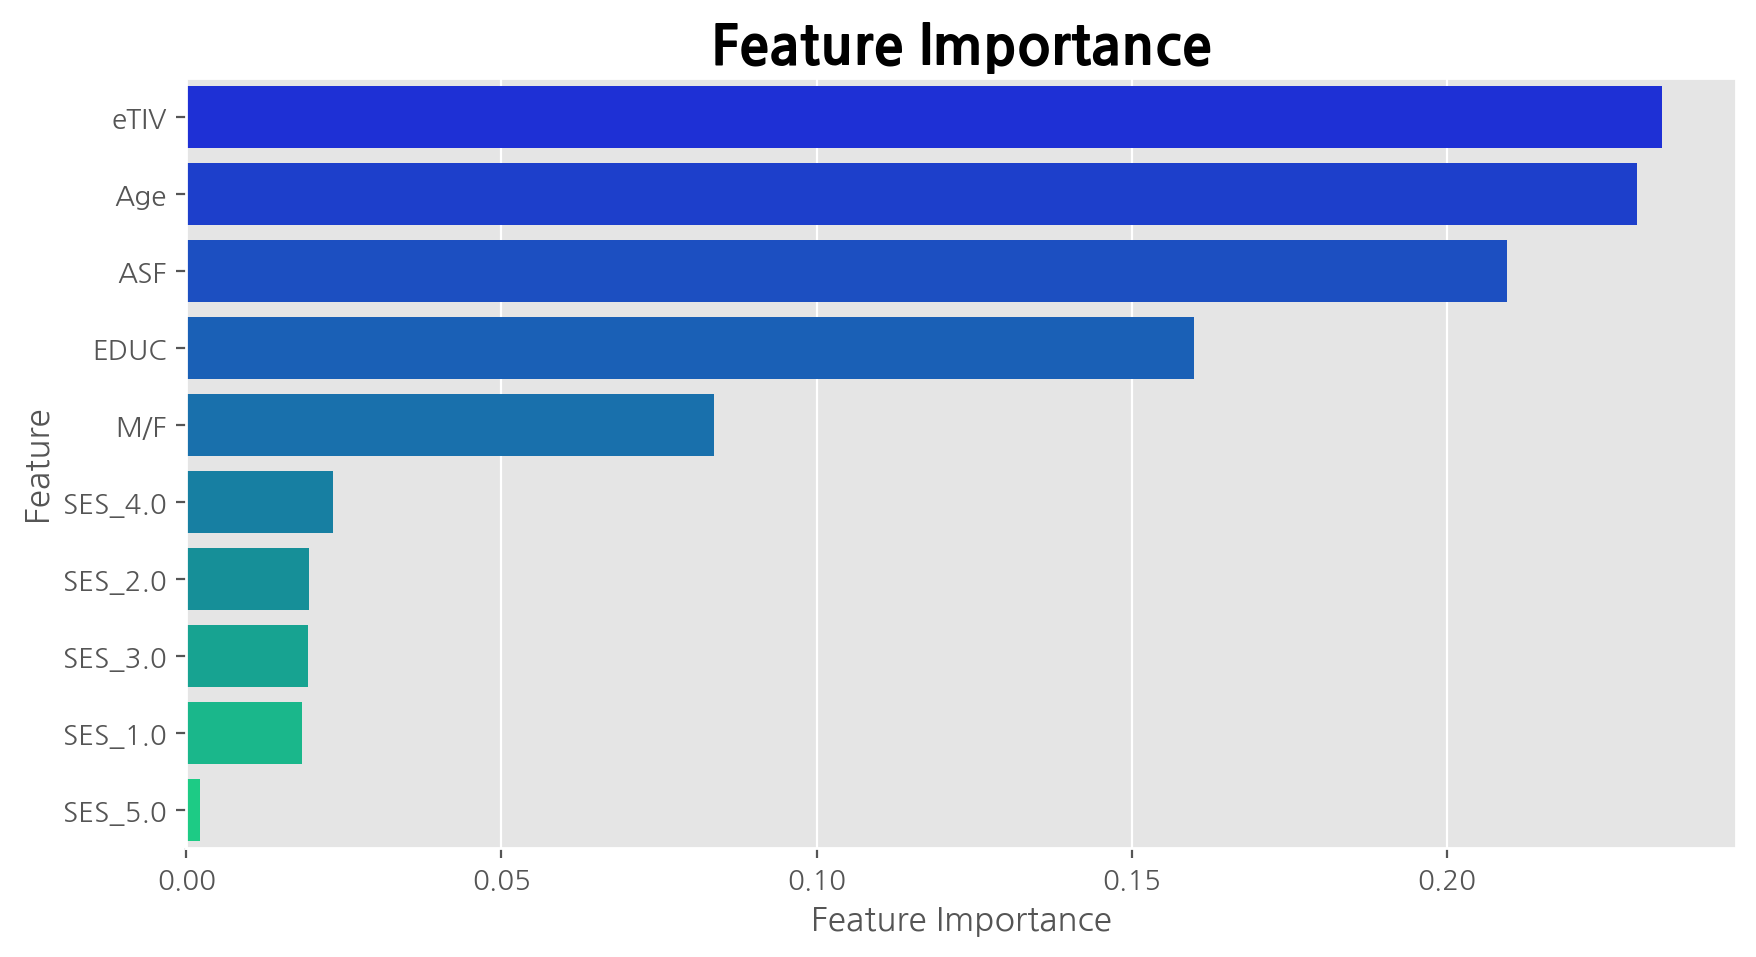

In [24]:
plt.figure(figsize = (10,5))


sns.barplot(data = importance,
            x = 'importance',
            y = 'feature',
            palette = 'winter')

plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.title('Feature Importance',fontsize = 20, weight = 'bold')

In [26]:
odds_ratio.to_csv('odds_ratio.csv',index = False)

In [28]:
importance.to_csv('feature_importacne.csv',index = False)